In [1]:
%matplotlib inline
from fastai.text import *
from collections import defaultdict
from tqdm.auto import tqdm

# Data Download
Get *Sentiment Analysis on Movie Reviews* dataset from Kaggle.

In [2]:
path = Config.data_path() / 'RottenTomatoes'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/lhe/.fastai/data/RottenTomatoes')

Uncomment the next two cells to download and unzip the data.

In [3]:
# ! kaggle competitions download -c sentiment-analysis-on-movie-reviews -p {path}


  0%|          | 0.00/471k [00:00<?, ?B/s]
100%|##########| 471k/471k [00:00<00:00, 4.98MB/s]

  0%|          | 0.00/583k [00:00<?, ?B/s]
100%|##########| 583k/583k [00:00<00:00, 7.48MB/s]

  0%|          | 0.00/1.21M [00:00<?, ?B/s]
 83%|########2 | 1.00M/1.21M [00:00<00:00, 7.73MB/s]
100%|##########| 1.21M/1.21M [00:00<00:00, 7.79MB/s]


In [4]:
# import zipfile
# for file in path.glob('*.zip'):
#     with zipfile.ZipFile(file, 'r') as zipref:
#         zipref.extractall(path)

# Data Inspection
Let's take a look at what's inside!

In [3]:
train = pd.read_csv(path / 'train.tsv', sep='\t')
test = pd.read_csv(path / 'test.tsv', sep='\t')
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Language Modeling
First let's create a good language model for this text classification problem.

In [4]:
tqdm.pandas()
splitter = defaultdict(lambda: np.random.sample() < 0.1)
np.random.seed(42)
for df in (train, test):
    df['is_valid'] = df['SentenceId'].progress_apply(splitter.__getitem__)

In [5]:
bs = 36

In [6]:
data_lm = (TextList.from_df(train, cols='Phrase', path=path)
           .add(TextList.from_df(test, cols='Phrase'))
           .split_from_df('is_valid')
           .label_for_lm()
           .databunch(bs=bs))

In [7]:
data_lm.save('data_lm.pkl')

In [6]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,goose xxbos escapades demonstrating the adage that what is good for the goose xxbos escapades xxbos demonstrating the adage that what is good for the goose xxbos demonstrating the adage xxbos demonstrating xxbos the adage xxbos the xxbos adage xxbos that what is good for the goose xxbos that xxbos what is good for the goose xxbos what xxbos is xxbos good for the goose xxbos good xxbos for the
1,of a comedy to start a reaction . xxbos ca n't generate enough heat in this cold vacuum of a comedy to start a reaction . xxbos ca n't generate enough heat in this cold vacuum of a comedy to start a reaction xxbos ca n't xxbos ca xxbos generate enough heat in this cold vacuum of a comedy to start a reaction xxbos generate enough heat xxbos enough heat
2,"tough - man contest xxbos action - packed an experience as a ringside seat xxbos action - packed an experience xxbos action - packed xxbos an experience xxbos as a ringside seat xxbos a ringside seat xxbos ringside seat xxbos ringside xxbos at a tough - man contest xxbos tough - man contest xxbos tough - man xxbos ... xxup -lrb- the film xxup -rrb- works , due mostly to"
3,", but xxbos xxmaj collateral xxmaj damage is trash , xxbos xxmaj collateral xxmaj damage is trash xxbos xxmaj collateral xxmaj damage xxbos xxmaj collateral xxbos xxmaj damage xxbos is trash xxbos it earns extra points by acting as if it were n't xxbos earns extra points by acting as if it were n't xxbos earns extra points xxbos earns xxbos extra points xxbos extra xxbos by acting as if"
4,"the film . xxbos labute ca n't avoid a fatal mistake in the modern era : xxmaj he 's changed the male academic from a lower - class xxmaj brit to an xxmaj american , a choice that upsets the novel 's exquisite balance and shreds the fabric of the film xxbos labute ca n't avoid a fatal mistake in the modern era : xxbos labute ca n't avoid a"


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


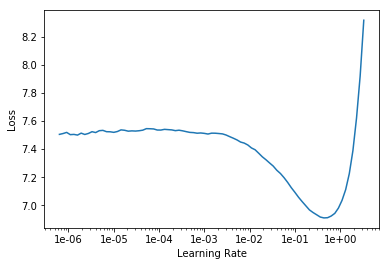

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.903738,5.176407,0.235211,04:02


In [11]:
learn.save('fit_head')

In [12]:
learn.save_encoder('head_enc')

In [9]:
learn.load('fit_head');

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


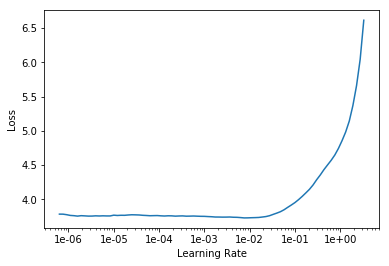

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.494552,3.409155,0.394955,05:01
1,3.097802,2.924835,0.476171,05:02
2,2.647582,2.481870,0.554678,04:59
3,2.354015,2.216336,0.602078,05:17
4,2.139511,2.066186,0.630144,06:02
5,2.003001,1.983346,0.647704,06:07
6,1.921366,1.931028,0.655466,06:06
7,1.861419,1.905116,0.660357,06:09
8,1.801625,1.896305,0.662366,06:10
9,1.794307,1.894467,0.662649,06:09


In [13]:
learn.save('fine_tuned')

In [14]:
learn.save_encoder('fine_tuned_enc')

# Classification
Train a classifier from the Language Model.  Because the classes are ordered, we'll train a multi-classification model with 4 classes: Rating greater than 0, rating greater than 1, etc.

In [15]:
def multiclass(sentiment, **_):
    return ' '.join(str(i) for i in range(sentiment))

In [16]:
train['multi_sent'] = train['Sentiment'].progress_apply(multiclass)

In [17]:
data_clas = (TextList.from_df(train, cols='Phrase', vocab=data_lm.vocab, path=path)
             .split_from_df('is_valid')
             .label_from_df(cols='multi_sent', label_delim=' ')
             .databunch(bs=bs))

In [18]:
data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [19]:
data_clas.show_batch()

text,target
"xxbos xxup -lrb- xxmaj city xxup -rrb- reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year .",0;1;2
"xxbos xxmaj while there 's likely very little crossover appeal to those without much interest in the xxmaj elizabethans xxup -lrb- as well as rank frustration from those in the know about xxmaj rubbo 's dumbed - down tactics xxup -rrb- , xxmaj much xxmaj ado xxmaj about xxmaj something is an amicable endeavor .",0;1;2
"xxbos xxmaj has none of the crackle of ` ` xxmaj fatal xxmaj attraction '' , ` ` 9 1 \ / 2 xxmaj weeks '' , or even ` ` xxmaj indecent xxmaj proposal '' , and feels more like xxmaj lyne 's stolid remake of ` ` xxmaj lolita ''",
"xxbos cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .",0;1;2;3
"xxbos xxmaj in addition to sporting one of the worst titles in recent cinematic history , xxmaj ballistic : xxmaj ecks xxmaj vs . xxmaj sever also features terrible , banal dialogue ; convenient , hole - ridden plotting ; superficial characters and a rather dull , unimaginative car chase .",


In [24]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy_thresh])
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


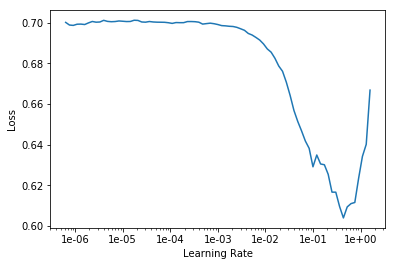

In [22]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.320677,0.311725,0.870891,05:16


In [26]:
learn.save('clas_fit_head')

In [ ]:
learn.load('clas_fit_head');

In [27]:
learn.freeze_to(-2)

In [29]:
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.290349,0.296170,0.884031,06:08


In [30]:
learn.save('clas_level_2')

In [ ]:
learn.load('clas_level_2');

In [31]:
learn.freeze_to(-3)

In [32]:
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.264785,0.273774,0.889899,05:14


In [33]:
learn.save('clas_level_3')

In [47]:
learn.load('clas_level_3');

In [48]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(2, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.239731,0.271980,0.891244,07:19
1,0.245423,0.267006,0.891939,07:36


In [50]:
learn.save('clas_fine_tuned')

In [51]:
learn.export()

# Predict Results

In [53]:
data_test = TextList.from_df(test, cols='Phrase', vocab=data_lm.vocab, path=path)

In [54]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

We expect conversion from multiclass predictions to single-class predictions to go as expected, with all the classes consistent with each other.  In the event of inconsistencies, we opt to take the "average" prediction.

In [60]:
from itertools import chain
from more_itertools import consecutive_groups

def to_single_class(multi):
    seq = itertools.chain((-1,), map(int, multi))
    return int(round(np.mean([max(sub) + 1 for sub in consecutive_groups(seq)])))

In [61]:
labelled_preds = [to_single_class(learn.data.classes[i] for i, p in enumerate(pred) if p > 0.5) for pred in tqdm(preds)]
labelled_preds[:5]

[2, 2, 3, 3, 3]

In [68]:
test['Sentiment'] = labelled_preds

In [69]:
test.head()

,PhraseId,SentenceId,Phrase,is_valid,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,False,2
1,156062,8545,An intermittently pleasing but mostly routine ...,False,2
2,156063,8545,An,False,3
3,156064,8545,intermittently pleasing but mostly routine effort,False,3
4,156065,8545,intermittently pleasing but mostly routine,False,3


In [70]:
test[['PhraseId', 'Sentiment']].to_csv('submission.csv', index=False)

In [72]:
# ! kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f submission.csv -m "My submission"

Successfully submitted to Sentiment Analysis on Movie Reviews



  0%|          | 0.00/647k [00:00<?, ?B/s]
  1%|1         | 8.00k/647k [00:00<00:09, 67.4kB/s]
100%|##########| 647k/647k [00:01<00:00, 532kB/s]  
